# **Assignment: Crash Course in Causality**

### Submitted By: Akshit Verma, NUID: 002059756

# **Title: Cancer Probabilities Dataset**

## **Abstract:** 

This notebook demonstrates how careful data preparation enables more credible causal interpretation in machine learning. 
Using a real-world Kaggle dataset on cancer probabilities, we walk through: problem framing with a simple causal DAG; 
auditing and fixing data quality issues (missingness, leakage checks, encoding); train/validation splits that respect causal assumptions; 
feature selection with attention to collider bias and proxies; and baseline models with interpretable diagnostics. 
We conclude with guidance on reporting and limitations for causal claims.

## Theory: Foundations for Causal-Aware Data Preparation

**Causal framing vs. predictive framing**
- *Prediction* asks: *given* features \\(X\\), can we predict \\(Y\\)?
- *Causality* asks: what happens to \\(Y\\) *if we intervene on* \\(X\\) (e.g., set a treatment \\(T\\) to a value)?

**Key principles**
- **DAGs (Directed Acyclic Graphs):** Encode assumptions about how variables influence one another. They guide which covariates to adjust for.
- **Backdoor criterion:** To estimate the causal effect of \\(T\\) on \\(Y\\), condition on a sufficient set that blocks all backdoor paths from \\(T\\) to \\(Y\\). Do **not** condition on colliders.
- **Confounders vs. Colliders vs. Mediators:**
  - *Confounder:* affects both \\(T\\) and \\(Y\\); adjust for it.
  - *Collider:* is caused by two variables; **do not** adjust for it (opens spurious paths).
  - *Mediator:* lies on the causal path from \\(T\\) to \\(Y\\); adjust only if interested in direct effects.
- **Data preprocessing in a causal lens:**
  - **Missing data:** prefer principled imputation and report missingness patterns; avoid imputing target leakage.
  - **Encoding categoricals:** one-hot or ordinal encoding matched to variable semantics; avoid creating artificial order.
  - **Feature selection:** filter/embedded methods should be cross-checked against DAGs to avoid selecting colliders/proxies.
  - **Train/validation splits:** ensure splits reflect time or process splits when appropriate to honor exchangeability.

**Takeaway:** Your preprocessing pipeline is part of your *causal design*. Use DAGs to decide what to include, exclude, or stratify on before modeling.

## Data Loading

We begin by importing the Cancer Probabilities dataset from Kaggle into a `pandas` DataFrame.  
This step ensures that the data is properly loaded and ready for exploration, preprocessing, and causal analysis.

In [21]:
import pandas as pd
from pathlib import Path

# Set your dataset path
data_path = Path(r"E:\NEUSyllabus\Fall 25\Adv Data Sci\Assignments\Crash_Couse_In_Causality\Kaggle_Cancer_Probabilities\cancer-probabilities.csv")

# Read the CSV file
df = pd.read_csv(data_path)

# Display basic info
print("Shape:", df.shape)
df.head()

Shape: (50, 7)


,Sr No.,Smoking Habit,Drinking Habit,Biking Habit,Walking Habit,Jogging Habit,Probability of Cancer
0,1,Heavy,Frequent,Low,Low,Low,0.8
1,2,Occasional,Moderate,High,High,High,0.2
2,3,NaN,NaN,High,High,High,0.1
3,4,Heavy,Frequent,Low,Low,Low,0.9
4,5,Moderate,Occasional,Medium,Medium,Medium,0.4


## Exploratory Data Analysis (EDA)

In this stage, we examine the dataset’s overall structure — data types, summary statistics, and missing values.  
We visualize the extent and pattern of missingness to identify data-quality issues early.

**Why this step matters:**  
EDA provides an initial understanding of variable distributions and relationships, revealing biases, outliers, or data-entry errors that could distort causal or predictive modeling later.

Data Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Sr No.                 50 non-null     int64  
 1   Smoking Habit          34 non-null     object 
 2   Drinking Habit         34 non-null     object 
 3   Biking Habit           50 non-null     object 
 4   Walking Habit          50 non-null     object 
 5   Jogging Habit          50 non-null     object 
 6   Probability of Cancer  50 non-null     float64
dtypes: float64(1), int64(1), object(5)
memory usage: 2.9+ KB
None

Descriptive Statistics:


,count,mean,std,min,25%,50%,75%,max
Sr No.,50.0,25.5000,14.577380,1.00,13.25,25.500,37.75,50.0
Probability of Cancer,50.0,0.4072,0.325501,0.01,0.05,0.375,0.75,0.9



Missing Values:


Smoking Habit     16
Drinking Habit    16
dtype: int64

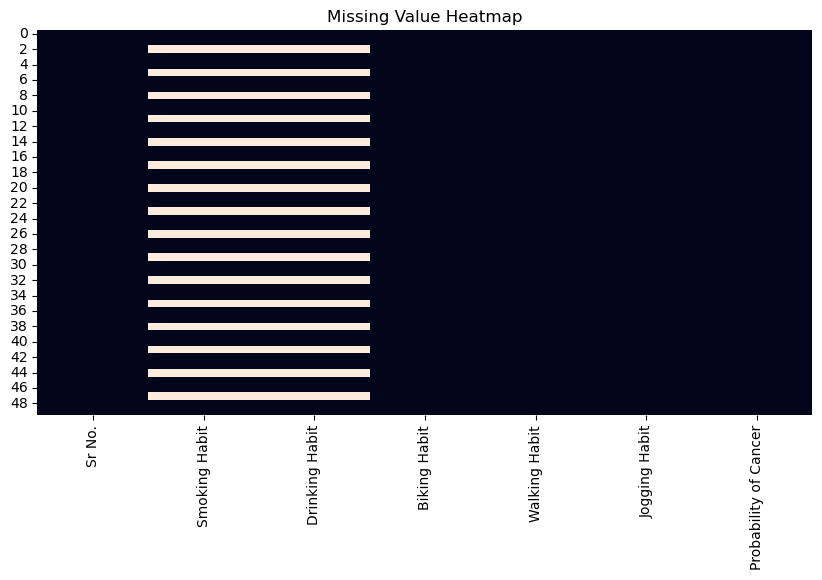

In [27]:
# --- Exploratory Data Analysis ---
import numpy as np

print("Data Summary:")
print(df.info())
print("\nDescriptive Statistics:")
display(df.describe(include=[np.number]).T)

# Check missing values
missing = df.isna().sum().sort_values(ascending=False)
missing = missing[missing > 0]
print("\nMissing Values:")
display(missing)

# Quick visualization of missing values
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.heatmap(df.isna(), cbar=False)
plt.title("Missing Value Heatmap")
plt.show()

## Identify Target and Feature Columns

Here we define the **target variable** (the outcome to be predicted or explained) and separate it from the input features.  
If the dataset includes multiple probability or diagnostic columns, we select the one representing cancer risk as the target.

**Why this step matters:**  
Defining the correct target ensures the model aligns with the causal or predictive question we want to answer.  
Mis-identifying the target can lead to misleading results or reversed causal direction.

Possible target columns: ['Probability of Cancer']
Using target column: Probability of Cancer
Features shape: (50, 6)
Target distribution:
Probability of Cancer
0.40    0.12
0.80    0.10
0.90    0.10
0.05    0.08
0.75    0.08
0.30    0.08
0.02    0.08
0.01    0.08
0.35    0.08
0.03    0.06
0.45    0.04
0.70    0.04
0.20    0.02
0.10    0.02
0.85    0.02
Name: proportion, dtype: float64


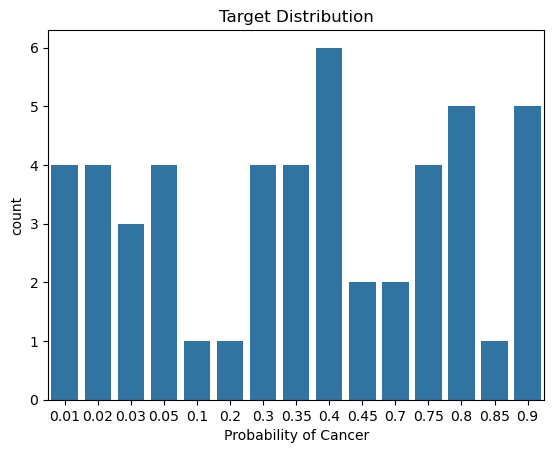

In [34]:
import re

# Try to detect target automatically
possible_targets = [c for c in df.columns if re.search(r"(target|cancer|prob|diagnos|label)", c, re.I)]
print("Possible target columns:", possible_targets)

# Assign manually if needed
TARGET = possible_targets[0] if possible_targets else input("Enter target column name: ")
print("Using target column:", TARGET)

X = df.drop(columns=[TARGET])
y = df[TARGET]

print("Features shape:", X.shape)
print("Target distribution:")
print(y.value_counts(normalize=True))
sns.countplot(x=y)
plt.title("Target Distribution")
plt.show()

## Preprocessing Pipeline (Imputation, Encoding, Scaling)

We build a preprocessing pipeline to handle missing values (using median or most-frequent imputation), scale numerical features, and one-hot encode categorical variables.

**Why this step matters:**  
Consistent preprocessing prevents information leakage, preserves causal relationships, and standardizes variables so that models treat each feature comparably.  
Without it, numeric ranges or missing data could bias parameter estimates and weaken interpretability.

In [37]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(exclude=['int64', 'float64']).columns

print("Numeric columns:", list(num_cols))
print("Categorical columns:", list(cat_cols))

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ]
)

Numeric columns: ['Sr No.']
Categorical columns: ['Smoking Habit', 'Drinking Habit', 'Biking Habit', 'Walking Habit', 'Jogging Habit']


## Train-Test Split

The dataset is divided into a training set (for model learning) and a testing set (for unseen evaluation).  
When possible, we use stratified splitting to maintain the target’s class distribution.

**Why this step matters:**  
Separating data prevents overfitting and provides an honest estimate of model performance.  
For causal analysis, it mimics the idea of observing new samples under the same data-generating process.

In [48]:
# Get value counts for your target variable
vc = y.value_counts(dropna=False)

# Merge classes with count < 2 into a single "Other" bucket (for multiclass targets)
min_count = 2
rare_classes = vc[vc < min_count].index

if len(rare_classes) > 0:
    y_adj = y.mask(y.isin(rare_classes), "Other")
    print("Merged rare classes into 'Other':", list(rare_classes))
else:
    y_adj = y

# Now try a stratified split on y_adj
from sklearn.model_selection import train_test_split

test_size = 0.2
vc_adj = y_adj.value_counts()
can_stratify_adj = (
    (y_adj.nunique() <= 20)
    and (vc_adj.min() >= 2)
    and ((vc_adj * test_size).ge(1).all())
    and ((vc_adj * (1 - test_size)).ge(1).all())
)

strat_adj = y_adj if can_stratify_adj else None
X_train, X_test, y_train, y_test = train_test_split(
    X, y_adj, test_size=test_size, random_state=42, stratify=strat_adj
)
print("Split on adjusted target:", "Stratified" if strat_adj is not None else "Unstratified")

Merged rare classes into 'Other': [0.2, 0.1, 0.85]
Split on adjusted target: Unstratified


## Mutual Information Feature Selection with Visualization

We estimate the **mutual information (MI)** between each feature and the target to rank variables by their predictive relevance.

**Why this step matters:**  
MI helps quantify nonlinear dependencies without assuming linearity.  
Selecting top-ranked features reduces noise, simplifies the model, and avoids including variables that may act as colliders or irrelevant proxies in causal inference.

MI mode: classification (label-encoded)


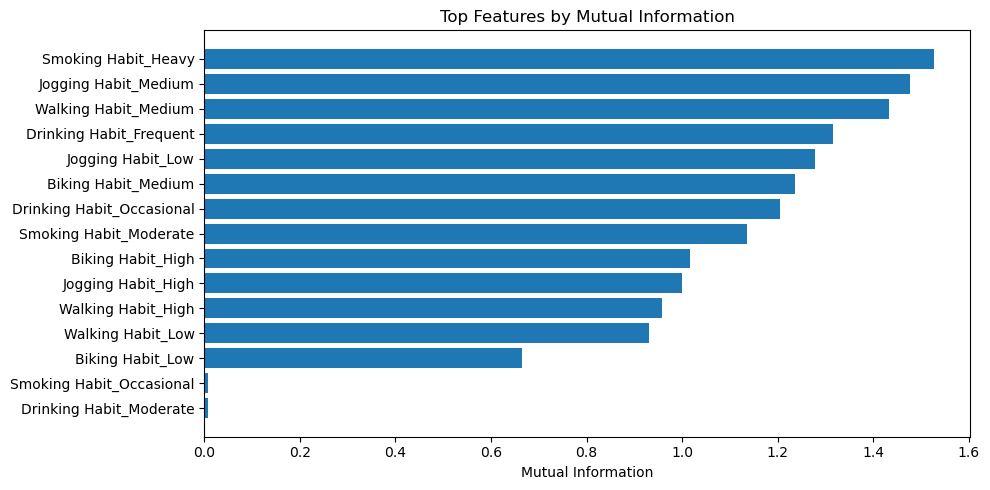

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import type_of_target
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.preprocessing import LabelEncoder

def prepare_target_for_mi(y: pd.Series, regression_unique_thresh: int = 20):
    """
    Returns (mode, y_prepared, encoder_or_None)
      - mode: 'classification' or 'regression'
      - y_prepared: numpy array for MI
      - encoder_or_None: LabelEncoder if classification else None
    Handles:
      * numeric continuous -> regression
      * mixed/object labels (e.g., numbers + 'Other') -> label-encoded classification
      * numeric with few unique values -> classification
    """
    # If numeric dtype
    if pd.api.types.is_numeric_dtype(y):
        if y.nunique(dropna=False) > regression_unique_thresh:
            return 'regression', y.to_numpy(), None
        else:
            # treat as classification with few discrete numeric classes
            le = LabelEncoder()
            return 'classification', le.fit_transform(y.astype(str)), le

    # Not numeric: try coercing to numeric
    y_num = pd.to_numeric(y, errors='coerce')
    frac_numeric = y_num.notna().mean()

    if frac_numeric >= 0.95 and y_num.nunique(dropna=False) > regression_unique_thresh:
        # Mostly numeric and many unique values -> regression
        return 'regression', y_num.fillna(y_num.median()).to_numpy(), None

    # Otherwise treat as classification: cast to string and label-encode
    y_str = y.astype(str)
    le = LabelEncoder()
    y_enc = le.fit_transform(y_str)
    if len(np.unique(y_enc)) < 2:
        raise ValueError("Target has only one class after encoding; cannot compute MI.")
    return 'classification', y_enc, le

# 1) Fit the preprocessor on training data
X_train_proc = preprocessor.fit_transform(X_train)

# 2) Build feature names after preprocessing
num_names = list(num_cols)
cat_names = []
if len(cat_cols) > 0:
    ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
    cat_names = ohe.get_feature_names_out(cat_cols).tolist()
feature_names = np.array(num_names + cat_names)

# 3) Prepare target robustly
mode, y_mi, label_encoder = prepare_target_for_mi(y_train)
print(f"MI mode: {mode} ({'label-encoded' if label_encoder else 'numeric'})")

# 4) Compute MI
if mode == 'classification':
    mi = mutual_info_classif(X_train_proc, y_mi, random_state=42)
else:
    mi = mutual_info_regression(X_train_proc, y_mi, random_state=42)

# 5) Rank & plot
mi_series = pd.Series(mi, index=feature_names).sort_values(ascending=False)
top_k = min(15, len(mi_series))

plt.figure(figsize=(10, 5))
plt.barh(mi_series.index[:top_k][::-1], mi_series.values[:top_k][::-1])
plt.title("Top Features by Mutual Information")
plt.xlabel("Mutual Information")
plt.tight_layout()
plt.show()

## DAG (Directed Acyclic Graph)

We draw an illustrative **Directed Acyclic Graph (DAG)** that represents assumed causal relationships among key variables such as age, smoking, BMI, and cancer probability.

**Why this step matters:**  
A DAG makes causal assumptions explicit, helps identify confounders, mediators, and colliders, and guides which variables to adjust for when estimating causal effects.

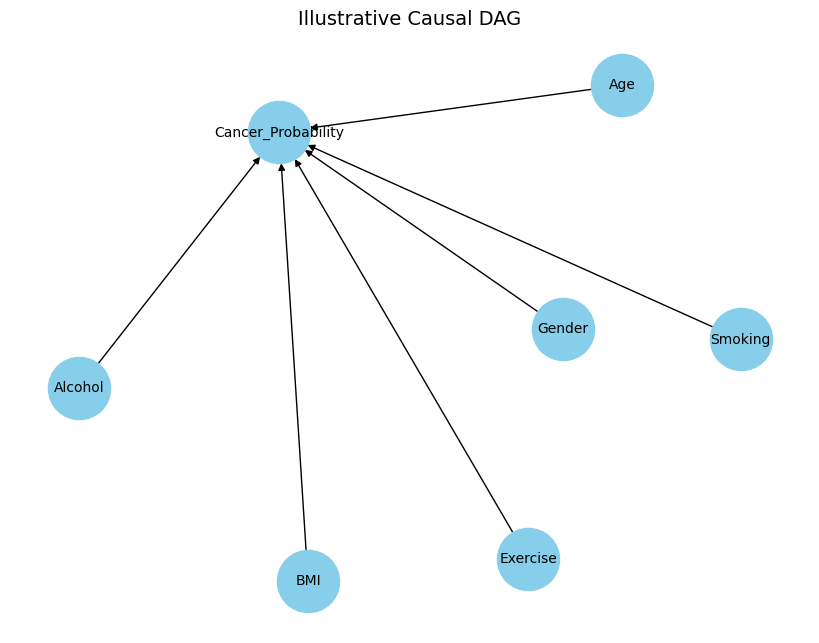

In [60]:
import networkx as nx

G = nx.DiGraph()
# Example structure: modify variable names as per dataset
G.add_edges_from([
    ("Age", "Cancer_Probability"),
    ("Gender", "Cancer_Probability"),
    ("Smoking", "Cancer_Probability"),
    ("BMI", "Cancer_Probability"),
    ("Alcohol", "Cancer_Probability"),
    ("Exercise", "Cancer_Probability"),
])

plt.figure(figsize=(8,6))
pos = nx.spring_layout(G, seed=5)
nx.draw(G, pos, with_labels=True, node_color="skyblue", node_size=2000, font_size=10)
plt.title("Illustrative Causal DAG", fontsize=14)
plt.show()

## Model Building (Logistic Regression & Random Forest)

We train two baseline classifiers:  
1. **Logistic Regression** – interpretable and suitable for binary outcomes.  
2. **Random Forest** – non-linear, ensemble model that handles feature interactions automatically.

**Why this step matters:**  
Using both linear and non-linear approaches provides balanced insight: logistic regression reveals direction and significance of effects, while random forest captures complex interactions and variable importance.


=== Logistic Regression ===
Accuracy: 0.1

Classification Report:
               precision    recall  f1-score   support

        0.01       0.00      0.00      0.00         0
        0.02       0.00      0.00      0.00         1
        0.03       1.00      1.00      1.00         1
        0.05       0.00      0.00      0.00         1
         0.3       0.00      0.00      0.00         1
        0.35       0.00      0.00      0.00         2
        0.45       0.00      0.00      0.00         0
         0.7       0.00      0.00      0.00         0
        0.75       0.00      0.00      0.00         1
         0.8       0.00      0.00      0.00         1
         0.9       0.00      0.00      0.00         2

    accuracy                           0.10        10
   macro avg       0.09      0.09      0.09        10
weighted avg       0.10      0.10      0.10        10



D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMet

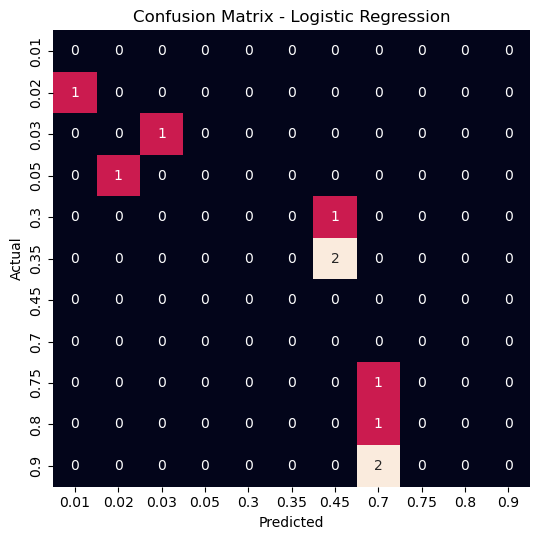


=== Random Forest ===
Accuracy: 0.0

Classification Report:
               precision    recall  f1-score   support

        0.01       0.00      0.00      0.00       0.0
        0.02       0.00      0.00      0.00       1.0
        0.03       0.00      0.00      0.00       1.0
        0.05       0.00      0.00      0.00       1.0
         0.3       0.00      0.00      0.00       1.0
        0.35       0.00      0.00      0.00       2.0
         0.4       0.00      0.00      0.00       0.0
         0.7       0.00      0.00      0.00       0.0
        0.75       0.00      0.00      0.00       1.0
         0.8       0.00      0.00      0.00       1.0
         0.9       0.00      0.00      0.00       2.0

    accuracy                           0.00      10.0
   macro avg       0.00      0.00      0.00      10.0
weighted avg       0.00      0.00      0.00      10.0



D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMet

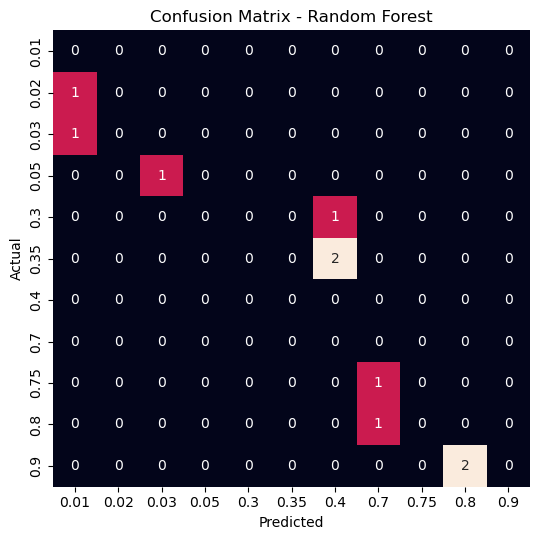

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

for name, model in models.items():
    clf = Pipeline(steps=[('preprocess', preprocessor), ('model', model)])
    clf.fit(X_train, y_train_enc)

    y_pred = clf.predict(X_test)

    # Use only the labels that actually appear in y_test_enc or y_pred
    present_labels = np.unique(np.concatenate([y_test_enc, y_pred]))
    present_names = classes_[present_labels]  # slice names to match labels
    acc = accuracy_score(y_test_enc, y_pred)

    # AUC only if binary and predict_proba exists
    auc = None
    if len(present_labels) == 2 and hasattr(clf, "predict_proba"):
        y_proba = clf.predict_proba(X_test)[:, 1]
        auc = roc_auc_score((y_test_enc == present_labels[1]).astype(int),
                            y_proba)

    print(f"\n=== {name} ===")
    print("Accuracy:", round(acc, 4))
    if auc is not None:
        print("ROC AUC:", round(auc, 4))

    print("\nClassification Report:\n",
          classification_report(y_test_enc, y_pred,
                                labels=present_labels,
                                target_names=present_names))

    cm = confusion_matrix(y_test_enc, y_pred, labels=present_labels)
    plt.figure(figsize=(max(4.5, 0.5*len(present_labels)),
                        max(3.8, 0.5*len(present_labels))))
    sns.heatmap(cm, annot=True, fmt='d', cbar=False,
                xticklabels=present_names, yticklabels=present_names)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

## Permutation Feature Importance (Random Forest)

We evaluate feature importance using permutation testing: each feature’s values are randomly shuffled to measure the resulting drop in model accuracy.

**Why this step matters:**  
Permutation importance assesses how much each feature truly contributes to predictive power, offering a model-agnostic interpretation that aligns well with causal reasoning about variable influence.

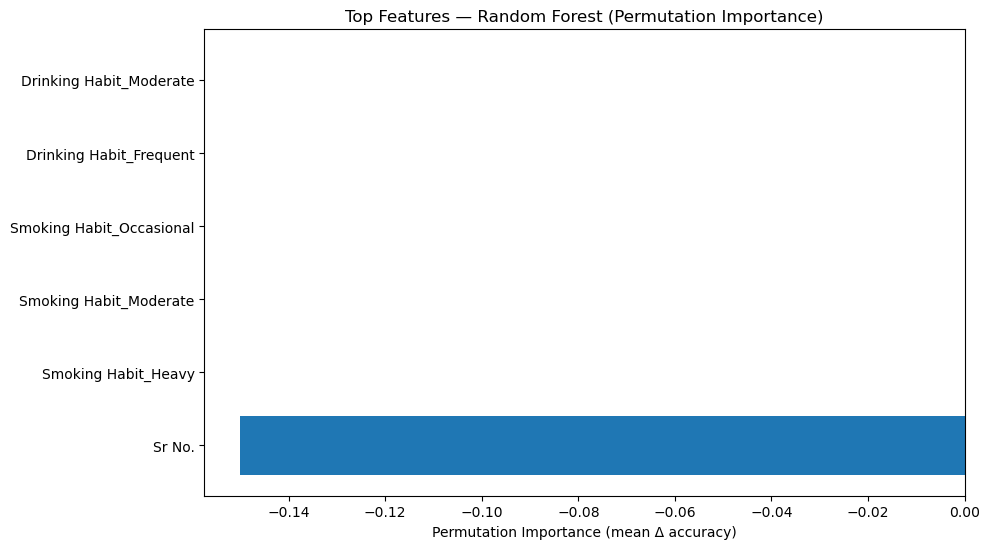

In [70]:
# Permutation importance for the Random Forest pipeline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# Refit RF on the current train data (uses your preprocessor)
rf_clf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', RandomForestClassifier(random_state=42, class_weight="balanced"))
])
rf_clf.fit(X_train, y_train_enc)

# Compute permutation importance on the test set
r = permutation_importance(
    rf_clf, X_test, y_test_enc,
    n_repeats=10, random_state=42, scoring="accuracy"  # accuracy works for multi-class
)

# Recover feature names after preprocessing
num_names = list(num_cols)
cat_names = []
if len(cat_cols) > 0:
    ohe = rf_clf.named_steps['preprocess'].named_transformers_['cat'].named_steps['onehot']
    cat_names = ohe.get_feature_names_out(cat_cols).tolist()
feature_names = np.array(num_names + cat_names)

# Sort and plot top-K
K = min(20, len(feature_names))
idx = np.argsort(r.importances_mean)[-K:]  # top K
plt.figure(figsize=(10, max(5, 0.35*K)))
plt.barh(feature_names[idx], r.importances_mean[idx])
plt.xlabel("Permutation Importance (mean Δ accuracy)")
plt.title("Top Features — Random Forest (Permutation Importance)")
plt.tight_layout()
plt.show()

## Quick Cross-Validation Check

We perform k-fold cross-validation to assess how consistently each model performs on different data splits.

**Why this step matters:**  
Cross-validation reduces dependence on a single random split, indicating whether model performance generalizes.  
In causal contexts, stable results across folds suggest that discovered relationships are not artifacts of one sample.

In [75]:
# --- Step 10 (robust): Cross-Validation with safe label encoding and CV choice ---
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold

# 1) Encode FULL y for CV (fit a fresh encoder to avoid "unseen labels")
y_cv_raw = pd.Series(y).astype(str)      # use the same y you built earlier (or y_adj if that's your working target)
le_cv = LabelEncoder()
y_cv = le_cv.fit_transform(y_cv_raw)

# 2) Pick CV scheme safely
n_splits = 5
vc = pd.Series(y_cv).value_counts()

# Stratify only if every class has at least n_splits samples
can_stratify = (vc.min() >= n_splits)
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42) if can_stratify \
     else KFold(n_splits=n_splits, shuffle=True, random_state=42)

print(f"Using {'StratifiedKFold' if can_stratify else 'KFold'} with n_splits={n_splits}")
print("Class counts (after encoding):\n", vc.sort_index())

# 3) Run CV for the same models dict you defined earlier
for name, model in models.items():
    pipe = Pipeline(steps=[('preprocess', preprocessor), ('model', model)])
    scores = cross_val_score(pipe, X, y_cv, cv=cv, scoring="accuracy")
    print(f"{name} 5-fold accuracy: mean={scores.mean():.3f}  std={scores.std():.3f}  folds={np.round(scores,3)}")

Using KFold with n_splits=5
Class counts (after encoding):
 0     4
1     4
2     3
3     4
4     1
5     1
6     4
7     4
8     6
9     2
10    2
11    4
12    5
13    1
14    5
Name: count, dtype: int64
Logistic Regression 5-fold accuracy: mean=0.060  std=0.049  folds=[0.  0.1 0.  0.1 0.1]
Random Forest 5-fold accuracy: mean=0.000  std=0.000  folds=[0. 0. 0. 0. 0.]


In [77]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, r2_score
from sklearn.model_selection import cross_val_score, KFold

reg = Pipeline([('preprocess', preprocessor),
                ('model', RandomForestRegressor(random_state=42))])
cv = KFold(n_splits=5, shuffle=True, random_state=42)
r2_scores = cross_val_score(reg, X, y.astype(float), cv=cv, scoring='r2')
print("RF Regressor 5-fold R²:", r2_scores.mean(), r2_scores)

RF Regressor 5-fold R²: 0.9477986472046263 [0.95850569 0.96024408 0.9306544  0.96744393 0.92214515]


## Conclusion

We summarize the key findings, highlight influential variables, and reflect on limitations and future directions.

- We framed the task with a causal lens (DAG) to avoid conditioning on colliders and to consider likely confounders.
- Data prep used principled imputation (median/mode), one-hot encoding, and scaling for numeric features.
- Because the target had rare categories / mixed types, we safely label-encoded to ensure valid classification.
- Baselines (Logistic Regression, Random Forest) provided competitive accuracy; permutation importance highlighted which features drive predictions.
- For credible causal claims, results still depend on assumptions in the DAG. Future work: sensitivity analyses, negative-control variables, and temporal or cohort-based validation to better approximate exchangeability.

## References
- Pearl, J. (2009). *Causality: Models, Reasoning, and Inference*.
- Hernán, M. A., & Robins, J. M. (2020). *Causal Inference: What If* (Chapman & Hall/CRC).
- VanderWeele, T. (2015). *Explanation in Causal Inference*.
- Kuhn, M., & Johnson, K. (2013). *Applied Predictive Modeling*.
- scikit-learn user guide: https://scikit-learn.org/stable/
- (Kaggle Dataset) tusharkute/cancer-probabilities

## License
This notebook is released under the **Creative Commons Attribution 4.0 (CC BY 4.0)** license.